<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
<center>Автор материала: Владимир Яшин (@vdyashin), студент-магистр ВШЭ

# <center> Метод прыжков для выбора числа кластеров

Известно, что, помимо обучения с учителем, в машинном обучении есть обучение без учителя. Задачи кластеризации являются задачами без учителя. Есть ряд методов кластеризации, которые требуют указать число кластеров (см. Spectral clustering, Ward hierarchical clustering, K-Means, Agglomerative clustering и другие методы). А что если мы изначально не знаем количество кластеров?

Примером области, где важно узнать число кластеров, может быть криминология. Криминалистам может понадобиться узнать количество людей, которые причастны к написанию как-то письма, будь-то электроенного или нет.  Урбанистам выбор числа кластеров может помочь понять, сколько разных районов в некоторой агломерации. Возможно, даже предсказать, в каких округах может возникнуть гетто. Такую задачу часто решают маркетологи, когда им нужно узнать, на сколько кластеров поделить своих клиентов, чтобы проводить таргетированные рекламные акции.

На одном из занятий научно-исследовательского семинара в университете мне было предложено реализовать один из алгоритмов, которые позволяют определить число кластеров в датасете. Алгоритм был предложен в статье:

    Sugar, C. A., & James, G. M. (2003). Finding the number of clusters in a dataset: An information-theoretic 
    approach. Journal of the American Statistical Association, 98(463), 750–763. JOUR.

Метод назвается методом "прыжков". Если коротко описывать алгоритм работы, то мы для выбранного диапазона $K$ в алгоритме $K$-средних, считаем внитриклассовую дисперсию, а потом смотрим ее прирост, подсчитанный с некоторым гипер-параметорм, и выбираем там, где такой прирост ("прыжок") был наибольший. Если ничего не понятно, то прочитайте этот небольшой мануал и вы, скорее всего, разберетесь.

Статья, которую вы сейчас читаете состоит из практической части, в которой метод будет использован скорее как "черный ящик". Прочитав только практическую часть, вы получите некоторое поверхностное представление о методе. Это ваша "программа минимум". Если захочется большего, то теоретическая часть, которая следует за практической, даст вам понимание того, как устроен алгоритм. Для того, чтобы понять _почему_ он работает, прочтайте исходную статью, ее можно найти в моем репозитории https://github.com/vdyashin/JumpMethod/blob/master/article/article.pdf.

## Практика

Давайте начнем с простых примеров, где мы знаем количество кластеров и распределения, из которых данные будем сэмплировать. 

In [1]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

Сейчас мы создадим четыре кластера на плоскости с известными нам средними и их матрицей ковариации.

Начнем с параметров. 

In [2]:
# means
Mu1, Mu2, Mu3, Mu4 = [-4, -4], [-4, 4], [4, -4], [4, 4]

# covariance
r = 0

# covariance matrix
Sigma = [[1, r], 
         [r, 1]]

# inverse the cov matrix
Sigma_inv = np.linalg.inv(Sigma)

# sample size
n = 1000

Теперь насэмплируем наблюдения. Тут нам поможет `numpy`.

In [3]:
# sample
c1 = np.random.multivariate_normal(mean = Mu1, cov = Sigma, size = n)
c2 = np.random.multivariate_normal(mean = Mu2, cov = Sigma, size = n)
c3 = np.random.multivariate_normal(mean = Mu3, cov = Sigma, size = n)
c4 = np.random.multivariate_normal(mean = Mu4, cov = Sigma, size = n)

# concatenate them into one dataset
C = np.row_stack([c1, c2, c3, c4])
print(C.shape)

(4000, 2)


Давайте посмотрим на получившийся датасет. Используем `matplotlib`.

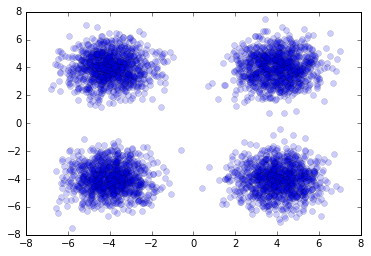

In [4]:
plt.plot(C[:, 0], C[:, 1], 'o', alpha=0.2);

В этом случае очень просто определить количество кластеров, даже не зная, что их было четыре. Однако, давайте проверим работу нашего алгоритма.

Сейчас я не хочу, чтобы вы вдавались в подробности того, как алгоритм работает. Если заинтересует, то почитайте потом раздел [теории](#theory), а пока просто пролистните следующую ячейку, ну или просто запустите, если открыли в ноутбуке. <a id='class'></a>

In [5]:
# import numpy as np
# from sklearn.cluster import KMeans

class JumpsMethod(object):
    """
    This class is initialized with dataset (data) and has two methods that help
    to calculate distortions and jumps -- the concepts proposed in 
        Sugar, C. A., & James, G. M. (2003). Finding the number of clusters in 
        a dataset: An information-theoretic approach. Journal of the American 
        Statistical Association, 98(463), 750–763. JOUR.
    """
    
    def __init__(self, data):
        self.data = data
        # dimension of 'data'; data.shape[0] would be size of 'data'
        self.p = data.shape[1]
        # vector of variances (1 by p)
        """ 'using squared error rather than Mahalanobis distance' (SJ, p. 12)
        sigmas = np.var(data, axis=0)
        ## by following the authors we assume 0 covariance between p variables (SJ, p. 12)
        # start with zero-matrix (p by p)
        self.Sigma = np.zeros((self.p, self.p), dtype=np.float32)
        # fill the main diagonal with variances for
        np.fill_diagonal(self.Sigma, val=sigmas)
        # calculate the inversed matrix
        self.Sigma_inv = np.linalg.inv(self.Sigma)"""
    
    
    def distortions(self, cluster_range=(1, 10), random_state=0):
        """ returns a vector of calculated distortions for each cluster number.
            If the number of clusters is 0, distortion is 0 (SJ, p. 2) 
            'cluster_range' -- range of numbers of clusters for KMeans;
            'data' -- n by p array """
        # dummy vector for Distortions
        self.distortions = np.repeat(0, cluster_range[1] + 1).astype(np.float32)

        # for each k in cluster range implement
        for k in range(cluster_range[0], cluster_range[1] + 1):
            # initialize and fit the clusterer giving k in the loop
            KM = KMeans(n_clusters=k, random_state=random_state)
            KM.fit(self.data)
            # calculate centers of suggested k clusters
            centers = KM.cluster_centers_
            # since we need to calculate the mean of mins create dummy vec
            for_mean = np.repeat(0, len(self.data)).astype(np.float32)

            # for each observation (i) in data implement
            for i in range(len(self.data)):
                # dummy for vec of distances between i-th obs and k-center
                dists = np.repeat(0, k).astype(np.float32)

                # for each cluster in KMean clusters implement
                for cluster in range(k):
                    # calculate the within cluster dispersion
                    tmp = np.transpose(self.data[i] - centers[cluster])
                    """ 'using squared error rather than Mahalanobis distance' (SJ, p. 12)
                    dists[cluster] = tmp.dot(self.Sigma_inv).dot(tmp)"""
                    dists[cluster] = tmp.dot(tmp)

                # take the lowest distance to a class
                for_mean[i] = min(dists)

            # take the mean for mins for each observation
            self.distortions[k] = np.mean(for_mean) / self.p

        return self.distortions
    
    
    def jumps(self, Y=None):
        """ returns a vector of jumps for each cluster """
        # if Y is not specified use the one that suggested by the authors (SJ, p. 2) 
        if Y is None:
            self.Y = self.p / 2
        
        else:
            self.Y = Y
        
        # the first (by convention it is 0) and the second elements
        self.jumps = [0] + [self.distortions[1] ** (-self.Y) - 0]
        self.jumps += [self.distortions[k] ** (-self.Y) \
                       - self.distortions[k-1] ** (-self.Y) \
                       for k in range(2, len(self.distortions))]
        
        # calculate recommended number of clusters
        self.recommended_cluster_number = np.argmax(np.array(self.jumps))
        
        return self.jumps

Начнем с инициализации класса. Класс принимает на вход данные.

In [6]:
JM = JumpsMethod(data=C)
print('Количество признаков:', JM.p)

Количество признаков: 2


Далее, прежде чем переходить к подсчету "прыжков", которые позволят нам показать, сколько кластеров оптимально выбрать, нужно подсчитать отклонения (distortions). В данном случае мы переберем с одного до десяти кластеров. Подсчитав в классе отклонения, можно посмотреть на их график в зависимости от числа кластеров.

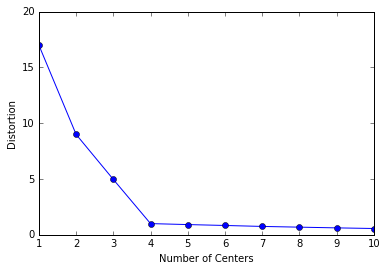

In [7]:
JM.distortions(cluster_range=(1, 10), random_state=13);

plt.plot(JM.distortions, '-o')
plt.ylabel('Distortion')
plt.xlabel('Number of Centers')
plt.xlim(1, 10)
plt.ylim(0, 20);

Наконец, подсчитаем значения "прыжков" и посмотрим на график.

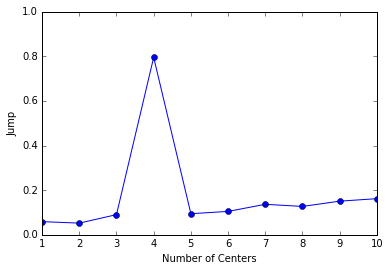

In [8]:
JM.jumps()

plt.plot(JM.jumps, '-o')
plt.ylabel('Jump')
plt.xlabel('Number of Centers')
plt.xlim(1, 10)
plt.ylim(0, 1);

Видим, что такой пример не вызывает затруднений у алгоритма. Давайте теперь попробуем более сложный пример. Будем использовать те же параметры, кроме средних значений.

In [9]:
# means
Mu1, Mu2, Mu3, Mu4 = [-2, -2], [-2, 2], [2, -2], [2, 2]

# covariance
r = 0

# covariance matrix (Gamma)
Sigma = [[1, r], 
         [r, 1]]
# inversed cov matrix
Sigma_inv = np.linalg.inv(Sigma)

# sample size
n = 1000

c1 = np.random.multivariate_normal(mean = Mu1, cov = Sigma, size = n)
c2 = np.random.multivariate_normal(mean = Mu2, cov = Sigma, size = n)
c3 = np.random.multivariate_normal(mean = Mu3, cov = Sigma, size = n)
c4 = np.random.multivariate_normal(mean = Mu4, cov = Sigma, size = n)

C = np.row_stack([c1, c2, c3, c4])

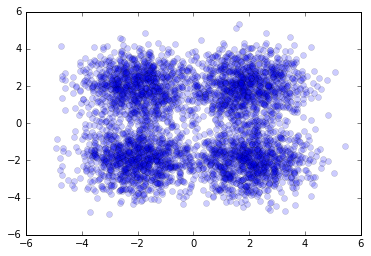

In [10]:
plt.plot(C[:, 0], C[:, 1], 'o', alpha=0.2)
plt.show()

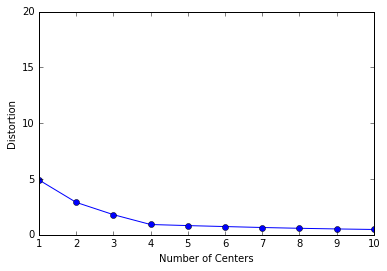

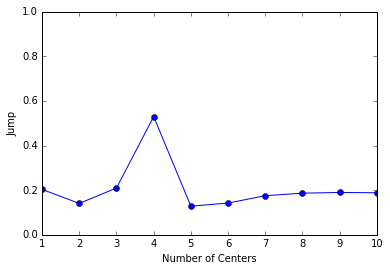

In [11]:
JM = JumpsMethod(data=C)

JM.distortions(cluster_range=(1, 10), random_state=13);

plt.plot(JM.distortions, '-o')
plt.ylabel('Distortion')
plt.xlabel('Number of Centers')
plt.xlim(1, 10)
plt.ylim(0, 20)
plt.show();

JM.jumps()

plt.plot(JM.jumps, '-o')
plt.ylabel('Jump')
plt.xlabel('Number of Centers')
plt.xlim(1, 10)
plt.ylim(0, 1);
plt.show();

Уже менее уверенно, но все же точно. Теперь пример еще сложнее.

In [12]:
# means
Mu1, Mu2, Mu3, Mu4 = [-1, -1], [-1, 1], [1, -1], [1, 1]

# covariance
r = 0

# covariance matrix (Gamma)
Sigma = [[1, r], 
         [r, 1]]
# inversed cov matrix
Sigma_inv = np.linalg.inv(Sigma)

# sample size
n = 1000

In [13]:
c1 = np.random.multivariate_normal(mean = Mu1, cov = Sigma, size = n)
c2 = np.random.multivariate_normal(mean = Mu2, cov = Sigma, size = n)
c3 = np.random.multivariate_normal(mean = Mu3, cov = Sigma, size = n)
c4 = np.random.multivariate_normal(mean = Mu4, cov = Sigma, size = n)

C = np.row_stack([c1, c2, c3, c4])

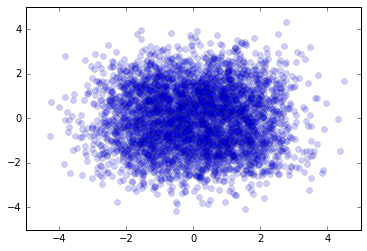

In [14]:
plt.plot(C[:, 0], C[:, 1], 'o', alpha=0.2)
plt.show()

Границы кластера вовсе не различимы. Посмотрим, что покажут результаты алгоритма.

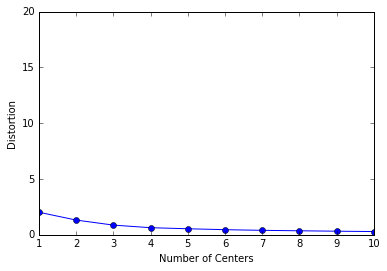

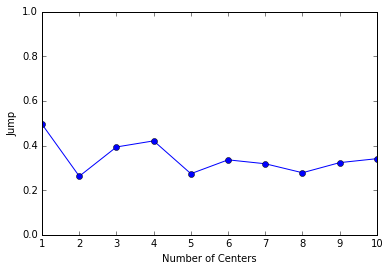

In [15]:
JM = JumpsMethod(data=C)

JM.distortions(cluster_range=(1, 10), random_state=13);

plt.plot(JM.distortions, '-o')
plt.ylabel('Distortion')
plt.xlabel('Number of Centers')
plt.xlim(1, 10)
plt.ylim(0, 20)
plt.show();

JM.jumps()

plt.plot(JM.jumps, '-o')
plt.ylabel('Jump')
plt.xlabel('Number of Centers')
plt.xlim(1, 10)
plt.ylim(0, 1);
plt.show();

Из последнего графика видно, что алгоритм совсем не справляется и показывает, что лучше всего принять количество кластеров за единицу. Чисто визуально, там действительно один кластер.

## Теория <a id='theory'></a>

Для того, чтобы перейти к обсуждению алгоритма, необходимо сперва дать определение наиболее важному и, как мне кажется, наиболее трудному для восприятия концепту отклонений (distortions), которые, по сути, являются внутриклассовой дисперсией. 

Положим $ D $ наши данные состоят из $ p $ признаков, каждый из которых набран из распредения с матрицей ковариации $ \Sigma $. Тогда $ x_i \in D $ многомерная случайная величина размерности $ p $. Так же определим $ c_1, c_2, \dots, c_K $ как центры кластеров для соответствующей случайной величины, причем, $ c_{x_i} $ ближайший центр кластера для $ x_i $. Тогда наименьшее достижимое отклонение для $ K $, полученных при применении метода K-средних

$$
d_K = \frac{1}{p} \min_{c_1, c_2, \dots, c_K} \mathbb{E} \Big[\big(x_i - c_{x_i}\big)^T \Sigma^{-1} \big(x_i - c_{x_i}\big)\Big]
$$

что является средним расстоянием Махаланобиса между $ x_i $ и $ c_{x_i} $ по всем $ p $ признакам. Очевидно, что нам редко известна матрица ковариаций $ \Sigma $, поэтому авторы метода предлагают использовать квадратичную ошибку (p. 12).

Обратите внимание, что на самом деле нужно подсчитать среднее минимумов, а не минимум средних. Возможно авторы просто ошиблись. Ну или я, но по-другому не работает.

Теперь перейдем непосредственно к алгоритму подсчета "прыжков".

1. Необходимо подсчитать $ \hat{d}_K $ для каждого из рассматриваемого количества кластеров, то есть нужно запустить метод $K$-средних для любого на ваш выбор диапазона $K$. На выходе получится вектор из отклонений длины, равной количеству перебираемых значений кластеров.
2. Выбрать гипер-параметр $ Y $, степень трансформации (transformation power). Авторы советуют начать подбор с $ Y = \frac{p}{2}$.
3. Подсчитать "прыжки" по формуле: $ J_K = \hat{d}^{-Y}_{K} - \hat{d}^{-Y}_{K-1} $. Проще говоря, это просто прирост отклонений. Будьте внимательны, $ d_0 := 0$.
4. Принять за $K^*$ такое количество кластеров, при котором $J$ максимальное. Технически: $ K^* = \arg \max_K J_K $. Обратите внимание, что метод может выбрать $ K^* = 1 $.

Моя попытка написать класс, который исполняет этот алгоритм, показана [выше](#class).

На этом все! Спасибо, если прочитал не только Практику, но и [Теорию](#theory). 

В этой статье я показал, как можно выбирать количество кластеров для алгоритма K-средних. Более детальное объяснение метода смотрите в исходной статье. Если захочется что-то законтрибьютить или поправить зайдите сюда: https://github.com/vdyashin/JumpMethod.